# Indexing

Aqui, veremos um fluxo de trabalho básico de indexação usando a API de indexação LangChain.

A API de indexação permite carregar e manter sincronizados documentos de qualquer fonte em um armazenamento de vetores. Especificamente, ajuda:

- Evitar escrever conteúdo duplicado no armazenamento de vetores;
- Evitar reescrever conteúdo inalterado;
- Evite recalcular incorporações sobre conteúdo inalterado
- Tudo isso deve economizar tempo e dinheiro, além de melhorar os resultados da pesquisa vetorial.

<mark> Fundamentalmente, a API de indexação funcionará mesmo com documentos que passaram por diversas etapas de transformação (por exemplo, por meio de agrupamento de texto) em relação aos documentos de origem originais.</mark>

## How it works
<hr>

A indexação LangChain utiliza um gerenciador de registros (RecordManager) que rastreia as gravações de documentos no armazenamento de vetores.

Ao indexar o conteúdo, os hashes são calculados para cada documento e as seguintes informações são armazenadas no gerenciador de registros:

- O hash do documento (hash do conteúdo da página e dos metadados)
- O date stamp de do documento no momento da operaçao
- O ID da fonte – cada documento deve incluir informações em seus metadados para nos permitir determinar a fonte final deste documento

## Deletion modes
<hr>

Ao indexar documentos em um armazenamento de vetores, é possível que alguns documentos existentes no armazenamento de vetores sejam excluídos. Em determinadas situações, você pode querer remover quaisquer documentos existentes derivados das mesmas fontes dos novos documentos que estão sendo indexados. Em outros, você pode querer excluir todos os documentos existentes. Os modos de exclusão da API de indexação permitem escolher o comportamento desejado:

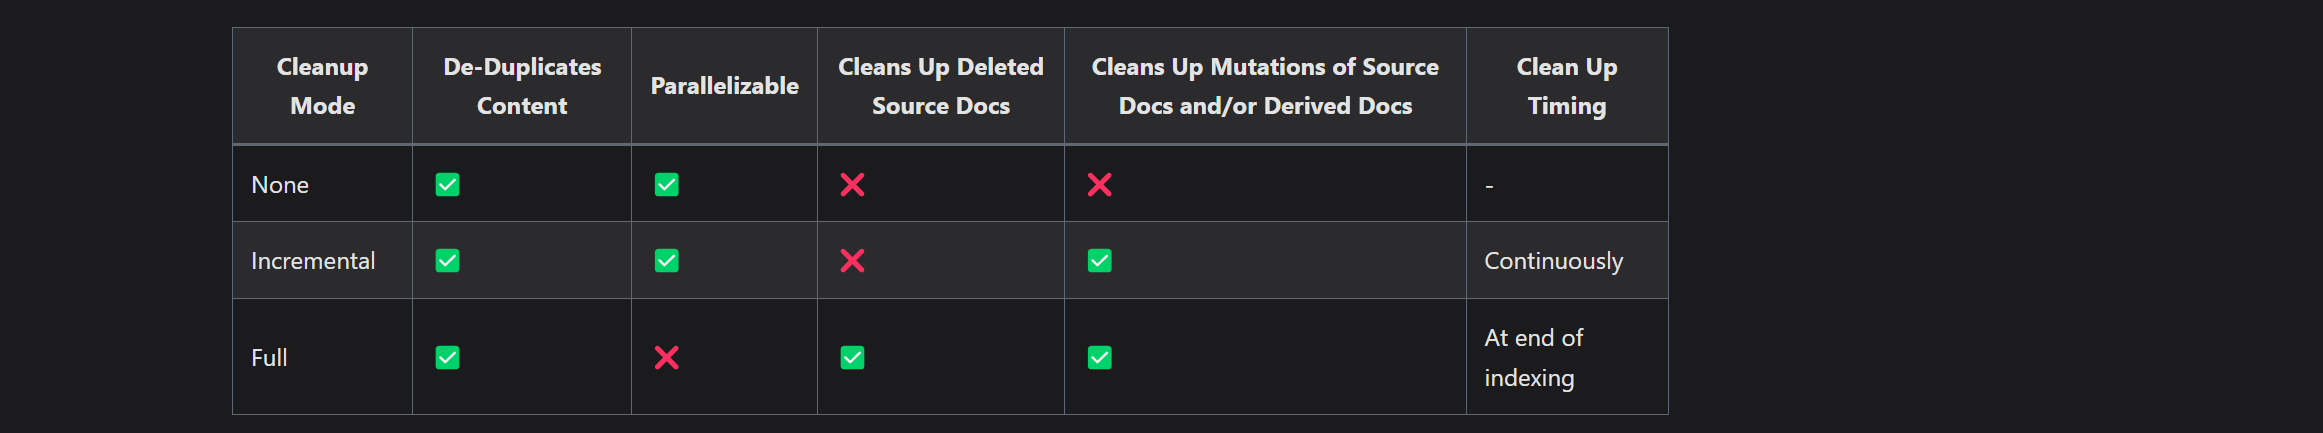

None não faz nenhuma limpeza automática, permitindo ao usuário limpar manualmente o conteúdo antigo.

Limpeza incremental e completa da proporcionam a seguinte limpeza automatizada:

    - Se o conteúdo do documento de origem ou dos documentos derivados tiver sido alterado, os modos incremental ou completo limparão (excluirão) versões anteriores do conteúdo.

    - Se o documento de origem tiver sido excluído (o que significa que não está incluído nos documentos atualmente indexados), o modo de limpeza completa irá excluí-lo do armazenamento de vetores corretamente, mas o modo incremental não.

Quando o conteúdo sofre mutação (por exemplo, o arquivo PDF de origem foi revisado), haverá um período durante a indexação em que as versões nova e antiga poderão ser devolvidas ao usuário. Isso acontece depois que o novo conteúdo foi escrito, mas antes da versão antiga ser excluída.

- a indexação incremental minimiza esse período de tempo, pois é capaz de fazer a limpeza continuamente enquanto grava.

- o modo completo faz a limpeza depois que todos os lotes foram gravados.

## Requirements
<hr>

1. Não utilize com um armazenamento que tenha sido pré-preenchido com conteúdo independentemente da API de indexação, pois o gerenciador de registros não saberá que os registros foram inseridos anteriormente.

2. Funciona apenas com vectorstore LangChain que suportam:
    - adição de documento por id (método add_documents com argumento ids)

    - excluir por id (método de exclusão com)

## Caution
<hr>

O gerenciador de registros depende de um mecanismo baseado em tempo para determinar qual conteúdo pode ser limpo (ao usar os modos de limpeza completa ou incremental).

Se duas tarefas forem executadas consecutivamente e a primeira tarefa for concluída antes da mudança de horário, a segunda tarefa poderá não conseguir limpar o conteúdo.

É improvável que isso seja um problema nas configurações reais pelos seguintes motivos:

    - O RecordManager usa carimbos de data/hora de resolução mais alta.

    - Os dados precisariam mudar entre a primeira e a segunda execução das tarefas, o que se torna improvável se o intervalo de tempo entre as tarefas for pequeno.

    - As tarefas de indexação normalmente demoram mais do que alguns ms.

In [1]:
# Processo de conexao do client na instancia do elasticsearch
from elasticsearch import Elasticsearch

client = Elasticsearch(
    "https://939f99d136aa4b5ab171889c1593d37c.us-central1.gcp.cloud.es.io:9243",  # Elasticsearch endpoint
    api_key=('2d82f3489d22486cb1cc34a32de30287', 'MFBBaEFJc0ItdUVkRFl2QjMxQmo6QjRnVmdaWjZTRmloaFZnRGZIaWJCQQ=='),  # API key ID and secret
)

## Quickstart
<hr>

API Reference:

<mark> OpenAi Embeddings </mark>
https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.openai.OpenAIEmbeddings.html


<mark> SQLRecordManagement </mark>
https://api.python.langchain.com/en/latest/indexes/langchain.indexes._sql_record_manager.SQLRecordManager.html

<mark> Index </mark>
https://api.python.langchain.com/en/latest/indexes/langchain.indexes._api.index.html


<mark> Document </mark>
https://api.python.langchain.com/en/latest/schema/langchain.schema.document.Document.html


<mark> Elasticstore </mark>
https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.elasticsearch.ElasticsearchStore.html


In [2]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.indexes import SQLRecordManager, index
from langchain.schema import Document
from langchain.vectorstores import ElasticsearchStore

In [3]:
# Modelo original de conexao local

vectorstore = ElasticsearchStore(
    es_url="http://localhost:9200", index_name="test_index", embedding=embedding
)

NameError: name 'embedding' is not defined

Inicialize um armazenamento de vetores e configure os embeddings:

In [5]:
cloud_id="30457331e52649c39b16776f8d5bc137:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDJkODJmMzQ4OWQyMjQ4NmNiMWNjMzRhMzJkZTMwMjg3JDkzOWY5OWQxMzZhYTRiNWFiMTcxODg5YzE1OTNkMzdj"

In [6]:
collection_name = "test_index"

embedding = OpenAIEmbeddings()


vectorstore = ElasticsearchStore(
    embedding=OpenAIEmbeddings(),
    index_name="test_index",
    es_cloud_id=cloud_id,
    es_user="elastic",
    es_password='CcP7PB23XsWCSo0NKZbBfd5I'
)

Inicialize um gerenciador de registros com um namespace apropriado.

Sugestão: Utilize um namespace que leve em consideração tanto o armazenamento de vetores quanto o nome da coleção no armazenamento de vetores; por exemplo, 'redis/my_docs', 'chromadb/my_docs' ou 'postgres/my_docs'.

In [7]:
namespace = f"elasticsearch/{collection_name}"
record_manager = SQLRecordManager(
    namespace, db_url="sqlite:///record_manager_cache.sql"
)


#Crie um esquema antes de usar o gerenciador de registros.
record_manager.create_schema()

Vamos indexar alguns documentos de teste:

In [ ]:
path_to_example_text = '/home/dani-boy/chat-langchain/Data/Nietzsche.txt'

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import TextLoader

with open(path_to_example_text) as f:
    document_text = f.read()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_text(document_text)

In [ ]:
doc1 = Document(page_content="kitty", metadata={"source": "kitty.txt"})
doc2 = Document(page_content="doggy", metadata={"source": "doggy.txt"})
doc3 = Document(page_content=document_text, metadata={"source": "nietzsche.txt"})

Indexando em um armazenamento de vetores vazio:

In [ ]:
def _clear():
    """Hacky helper method to clear content. See the `full` mode section to to understand why it works."""
    index([], record_manager, vectorstore, cleanup="full", source_id_key="source")

### None deletion mode

Este modo não faz limpeza automática de versões antigas de conteúdo; no entanto, ainda cuida da desduplicação de conteúdo.

In [ ]:
_clear()

In [ ]:
index(
    [doc1, doc1, doc1, doc1, doc1],
    record_manager,
    vectorstore,
    cleanup=None,
    source_id_key="source",
)

In [ ]:
_clear()

In [ ]:
index(
    [doc1, doc2, doc3], record_manager, vectorstore, cleanup=None, source_id_key="source"
)

Na segunda vez, todo o conteúdo será ignorado:

In [ ]:
index(
    [doc1, doc2], record_manager, vectorstore, cleanup=None, source_id_key="source"
)

### "incremental" deletion mode

In [ ]:
_clear()

In [ ]:
index(
    [doc1, doc2, doc3],
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

A indexação novamente deve fazer com que ambos os documentos sejam ignorados - ignorando também a operação de incorporação!

In [ ]:
index(
    [doc1, doc2],
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

Se não fornecermos documentos com modo de indexação incremental, nada mudará.

In [ ]:
index(
    [], record_manager, vectorstore, cleanup="incremental", source_id_key="source"
)

Se alterarmos um documento, a nova versão será escrita e todas as versões antigas que compartilhem a mesma fonte serão excluídas.

In [ ]:
changed_doc_2 = Document(page_content="puppy", metadata={"source": "doggy.txt"})

In [ ]:
index(
    [changed_doc_2],
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

### "full" deletion mode

No modo completo o usuário deve passar todo o universo de conteúdo que deve ser indexado para a função de indexação.

Quaisquer documentos que não sejam passados ​​para a função de indexação e estejam presentes no vectorstore serão excluídos!

Este comportamento é útil para lidar com exclusões de documentos de origem.

In [ ]:
_clear()

In [ ]:
all_docs = [doc1, doc2]

In [ ]:
index(all_docs, record_manager, vectorstore, cleanup="full", source_id_key="source")

Say someone deleted the first doc:

In [ ]:
del all_docs[0]

In [ ]:
all_docs

Using full mode will clean up the deleted content as well.

In [ ]:
index(all_docs, record_manager, vectorstore, cleanup="full", source_id_key="source")

## Source
<hr>

O atributo de metadados contém um campo chamado source. Esta fonte deve apontar para a proveniência final associada ao documento em questão.

Por exemplo, se esses documentos representarem partes de algum documento pai, a origem de ambos os documentos deverá ser a mesma e fazer referência ao documento pai.

Em geral, a fonte deve sempre ser especificada. Use None apenas se você nunca pretende usar o modo incremental e, por algum motivo, não consegue especificar o campo de origem corretamente.

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

API Reference:
https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.CharacterTextSplitter.html

In [ ]:
doc1 = Document(
    page_content="kitty kitty kitty kitty kitty", metadata={"source": "kitty.txt"}
)
doc2 = Document(page_content="doggy doggy the doggy", metadata={"source": "doggy.txt"})

In [ ]:
new_docs = CharacterTextSplitter(
    separator="t", keep_separator=True, chunk_size=12, chunk_overlap=2
).split_documents([doc1, doc2])
new_docs

In [ ]:
_clear()

In [ ]:
index(
    new_docs,
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

In [ ]:
changed_doggy_docs = [
    Document(page_content="woof woof", metadata={"source": "doggy.txt"}),
    Document(page_content="woof woof woof", metadata={"source": "doggy.txt"}),
]

Isso deve excluir as versões antigas dos documentos associados à fonte doggy.txt e substituí-los pelas novas versões.

In [ ]:
index(
    changed_doggy_docs,
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

In [ ]:
vectorstore.similarity_search("Weimar", k=30)

## Using with loaders

<hr>

A indexação pode aceitar um iterável de documentos ou qualquer carregador.

Atenção: O carregador deve configurar as chaves de origem corretamente.

In [ ]:
from langchain.document_loaders.base import BaseLoader


class MyCustomLoader(BaseLoader):
    def lazy_load(self):
        text_splitter = CharacterTextSplitter(
            separator="t", keep_separator=True, chunk_size=12, chunk_overlap=2
        )
        docs = [
            Document(page_content="woof woof", metadata={"source": "doggy.txt"}),
            Document(page_content="woof woof woof", metadata={"source": "doggy.txt"}),
        ]
        yield from text_splitter.split_documents(docs)

    def load(self):
        return list(self.lazy_load())

api reference: https://api.python.langchain.com/en/latest/document_loaders/langchain.document_loaders.base.BaseLoader.html

In [ ]:
_clear()

In [ ]:
loader = MyCustomLoader()

In [ ]:
loader.load()

In [ ]:
index(loader, record_manager, vectorstore, cleanup="full", source_id_key="source")

In [ ]:
vectorstore.similarity_search("dog", k=30)

In [ ]:
elastic_id = '2d82f3489d22486cb1cc34a32de30287'

elastic_end_point = 'https://2d82f3489d22486cb1cc34a32de30287.us-central1.gcp.cloud.es.io'


deployment_id = '30457331e52649c39b16776f8d5bc137'

In [ ]:
kibana_id = '939f99d136aa4b5ab171889c1593d37c'

kibana_end_point = 'https://939f99d136aa4b5ab171889c1593d37c.us-central1.gcp.cloud.es.io:9243'

In [ ]:
from elasticsearch import Elasticsearch
es = Elasticsearch(
    cloud_id="30457331e52649c39b16776f8d5bc137:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDJkODJmMzQ4OWQyMjQ4NmNiMWNjMzRhMzJkZTMwMjg3JDkzOWY5OWQxMzZhYTRiNWFiMTcxODg5YzE1OTNkMzdj"
)

In [ ]:
ELASTIC_PASSWORD = "<password>"

In [ ]:
kibana_end_point = 'https://939f99d136aa4b5ab171889c1593d37c.us-central1.gcp.cloud.es.io:9243'

In [ ]:
from langchain.vectorstores import ElasticsearchStore
from langchain.embeddings.openai import OpenAIEmbeddings

In [ ]:
from elasticsearch import Elasticsearch

In [ ]:
es_connection = Elasticsearch("http://localhost:9200")

ElasticsearchStore by default uses the ApproxRetrievalStrategy, which uses the HNSW algorithm to perform approximate nearest neighbor search. This is the fastest and most memory efficient algorithm.

In [ ]:
vectorstore = ElasticsearchStore(
    embedding=OpenAIEmbeddings(),
    index_name="langchain-demo",
    es_connection=es_connection
)

If you want to use the Brute force / Exact strategy for searching vectors, you can pass in the ExactRetrievalStrategy to the ElasticsearchStore constructor.

In [ ]:
from langchain.vectorstores import ElasticsearchStore
from langchain.embeddings.openai import OpenAIEmbeddings

vectorstore = ElasticsearchStore(
    embedding=OpenAIEmbeddings(),
    index_name="langchain-demo",
    es_url="http://localhost:9200",
    strategy=ElasticsearchStore.ExactRetrievalStrategy()
)

In [ ]:
from langchain.schema import Document
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import ElasticsearchStore
import os
#import getpass

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

embeddings = OpenAIEmbeddings()

In [ ]:
docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "rating": 9.9,
            "director": "Andrei Tarkovsky",
            "genre": "science fiction",
            "rating": 9.9,
        },
    ),
]

In [ ]:
Document = [(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    )]

In [ ]:
es_connection = Elasticsearch("http://localhost:9200")

In [ ]:
vectorstore = ElasticsearchStore.from_documents(
                            documents=docs, 
                            embedding=OpenAIEmbeddings(), 
                            index_name="elasticsearch-self-query-demo", 
                            es_connection=es_connection
)

In [ ]:
vectorstore = ElasticsearchStore(
    embedding=OpenAIEmbeddings(),
    index_name="langchain-demo",
    es_connection=es_connection
)